In [ ]:
########################################################################
# Author    : A. Alsema
# Date      : January 2022
# Dataset   : Visium Spatial Transcriptomics for MS lesions
# Purpose   : from the MS prioritized gene list count how often they occur in each cluster.
# Output    : csv file gwas-enrichment.csv 

# Note: Sample C2 had only 1 cluster, making it impossible to scale average gene expression across clusters.
# Note: identical procedure was performed for GM samples.

# Required Inputs:
# - gwas: 393 MS risk genes stored in csv file. Please find this in data_files/extended data figures/ExtDataFig6/
# - indir: location of the sce objects with bayesspace clustering result
# - outdir: location for storing results 
# - sampleIDs: vector of sample ids to process 

#########################################################################


In [33]:
# load libraries
rm(list = ls())
library(BayesSpace)
library(scuttle)
library(dplyr)

In [34]:
indir = "<your_indir>"
outdir = "<your_outdir>"

# load gene list
gwas <- read.csv("our_genesets/MS_prioritized genes 393 filtered.csv") 
gwas.genes <- gwas$X
print('number of gwas genes considered:')
print(length(gwas.genes))

[1] "number of gwas genes considered:"
[1] 393


[1] "ST31"
  counted.gwas
1            0
2            0
[1] "ST32"


Warning message in plot_GWAS_genes_per_cluster(sampleIDs, indir, gwas.genes):
“Warning: cannot compute ST32 . There were no GWAS genes in the sample. Skipping this sample.”


[1] "ST33"
   counted.gwas
1            11
2            39
3             2
4            10
5            26
6            31
7             2
8            34
9            55
10            2


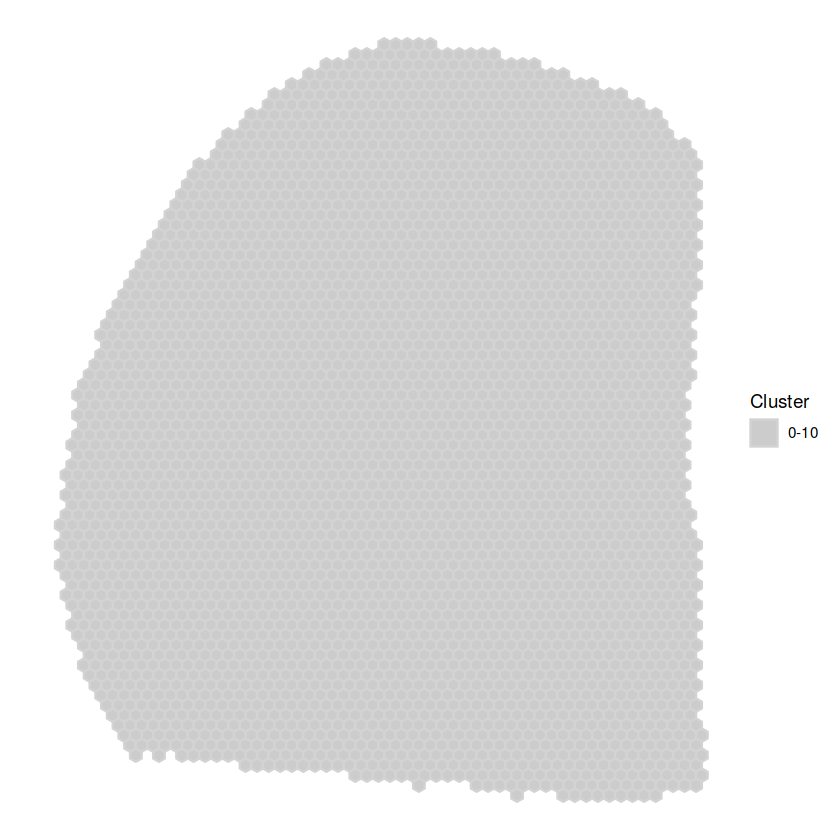

[1] "ST34"
  counted.gwas
1            0
2            0


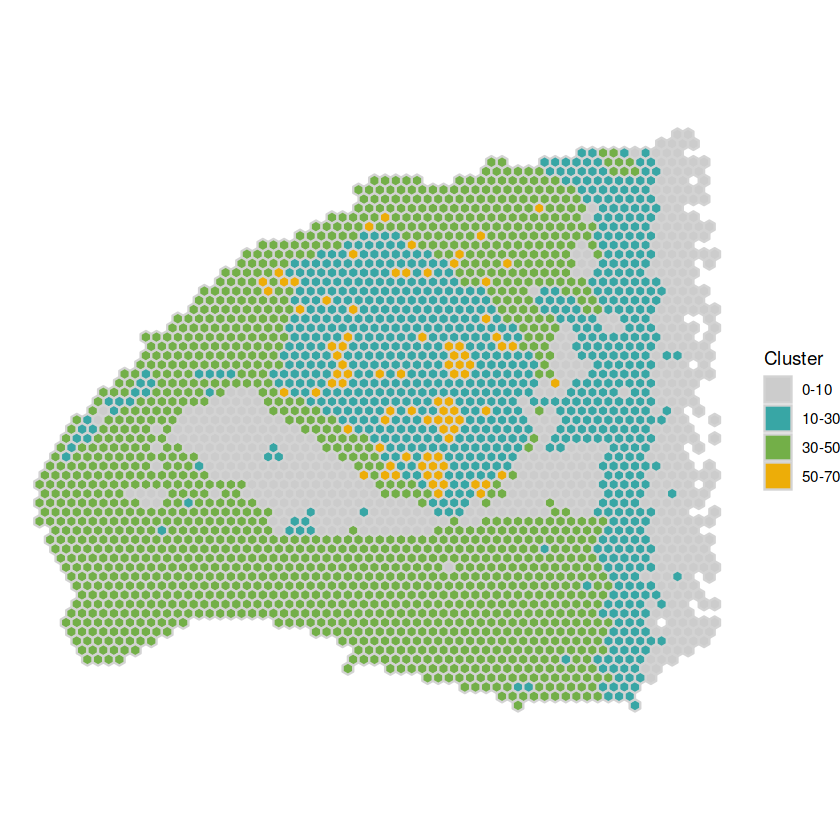

[1] "ST37"
  counted.gwas
1            0
2            0


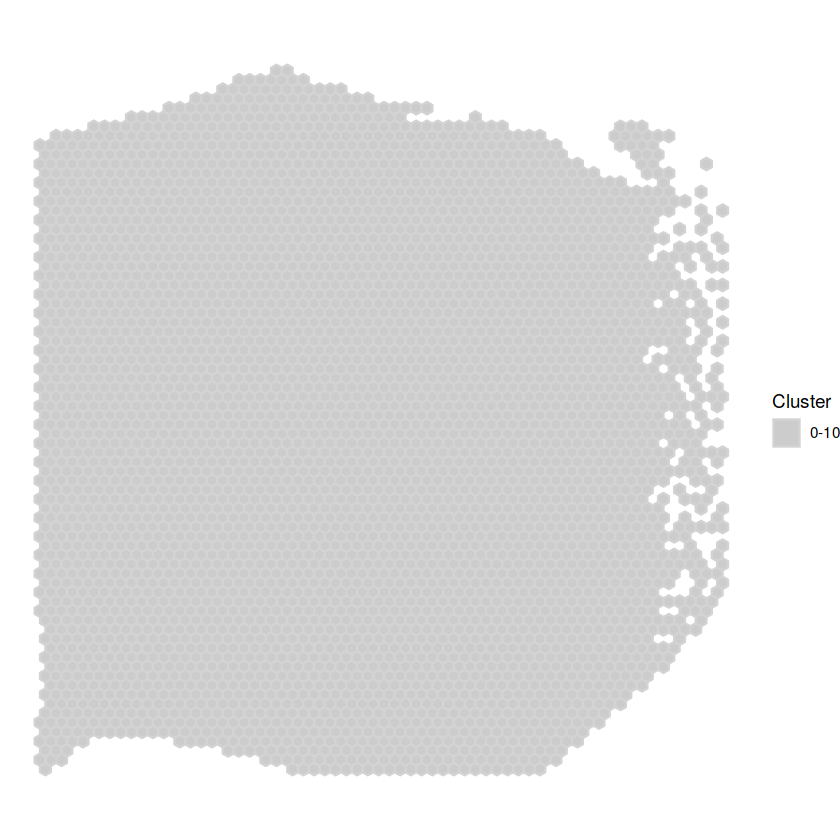

[1] "ST38"
  counted.gwas
1            0
2            0
3            0


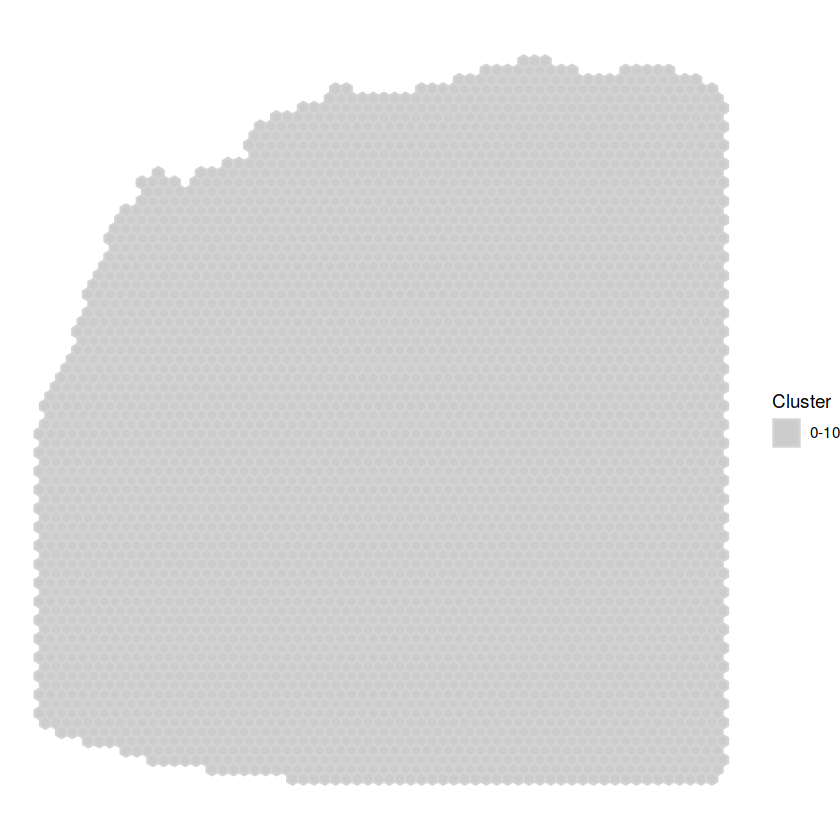

[1] "ST67"
  counted.gwas
1            3
2           20
3          160
4            9
5            9
6            5
7            1
8           15
9           25


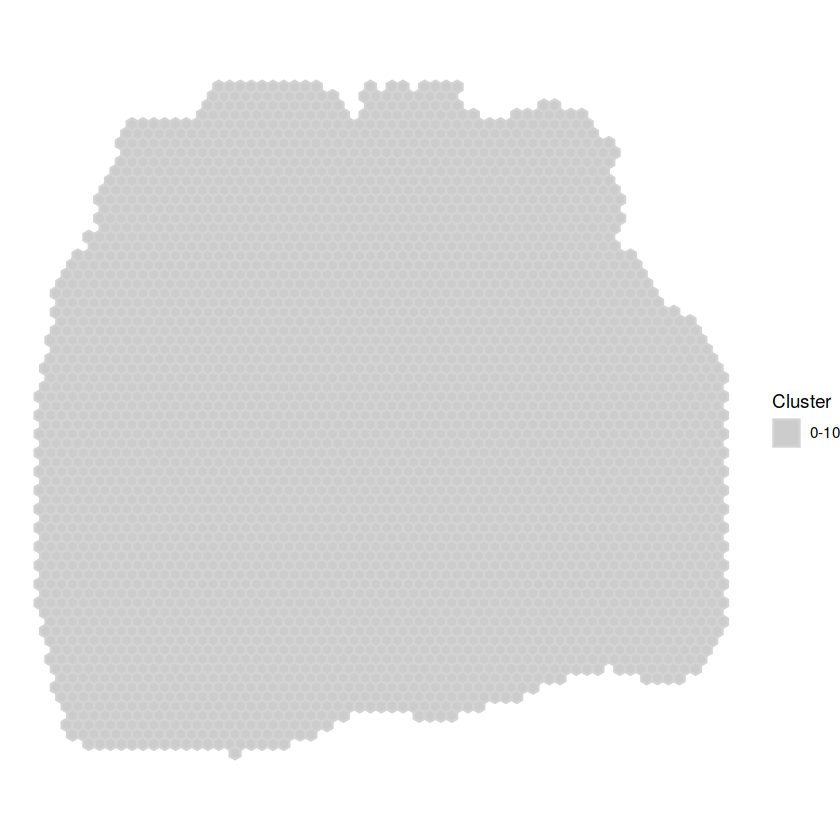

[1] "ST68"
  counted.gwas
1            7
2           87
3            2
4            4
6           70
7           36
8           14


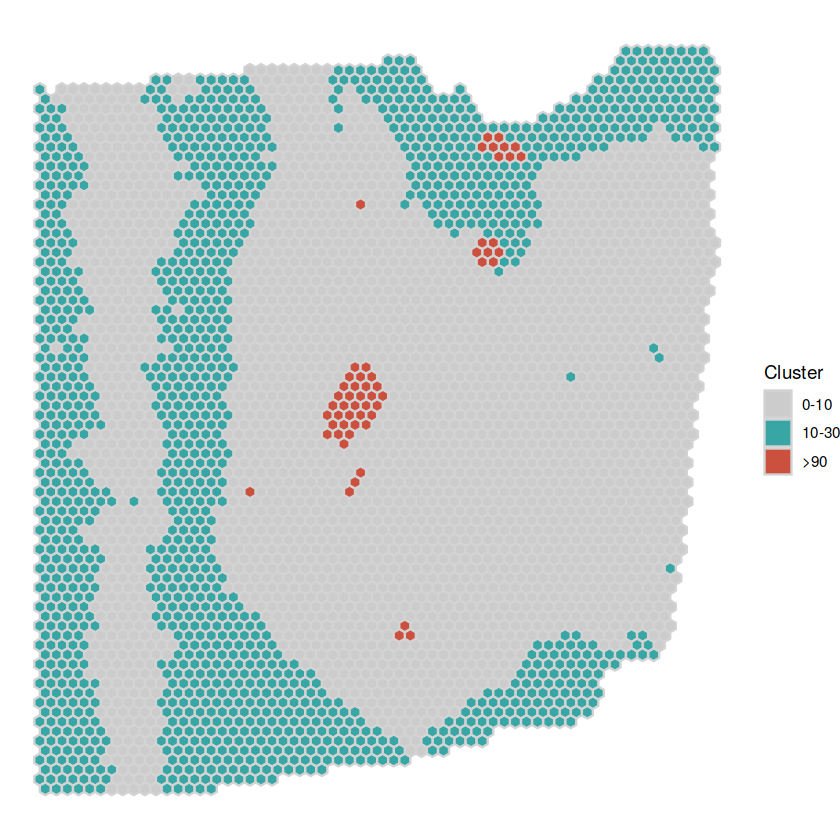

[1] "ST69"
  counted.gwas
1            2
2            6
3           12
4           19
5          149
6           10


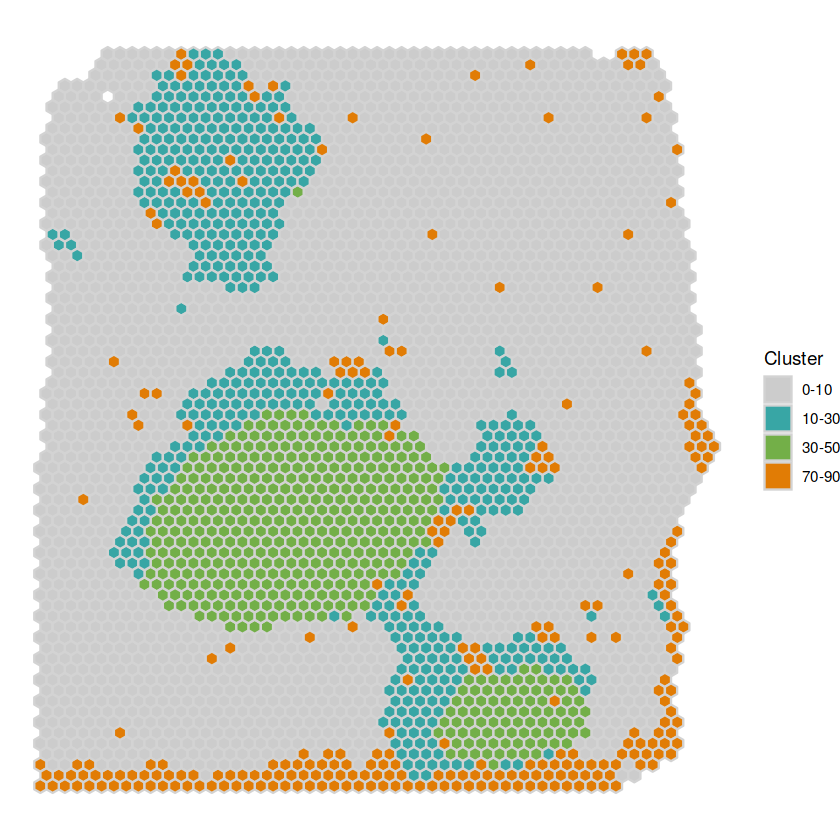

[1] "ST70"
  counted.gwas
1            3
2            4
3            9
4            7
5            8
6           73
7          119


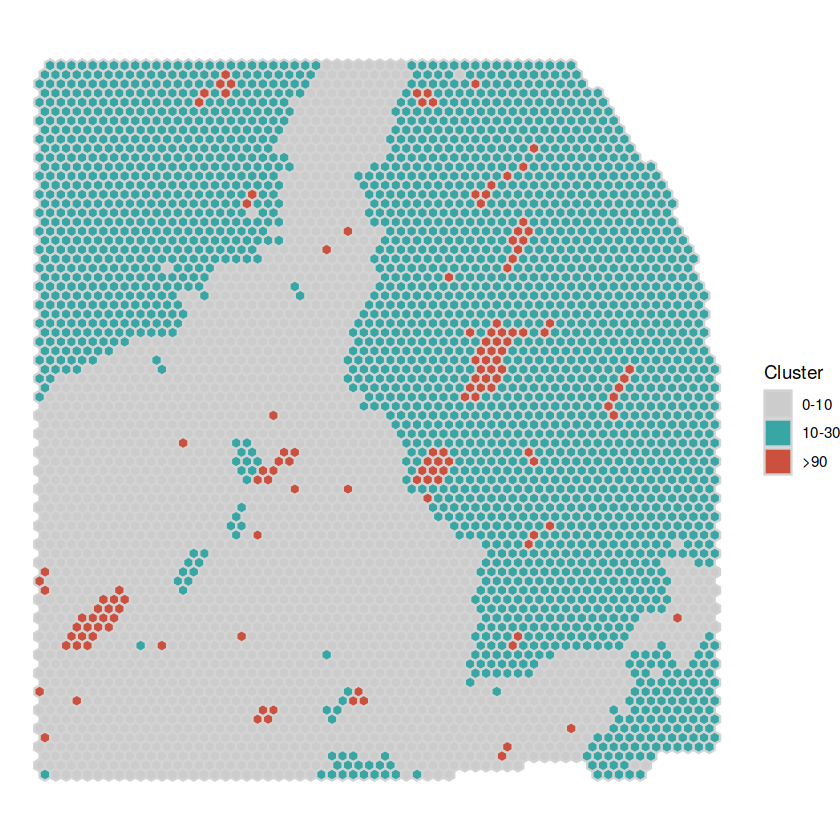

[1] "ST71"
  counted.gwas
1            8
2           13
3           59
4           19
5           15
6           78
7           27
8            4


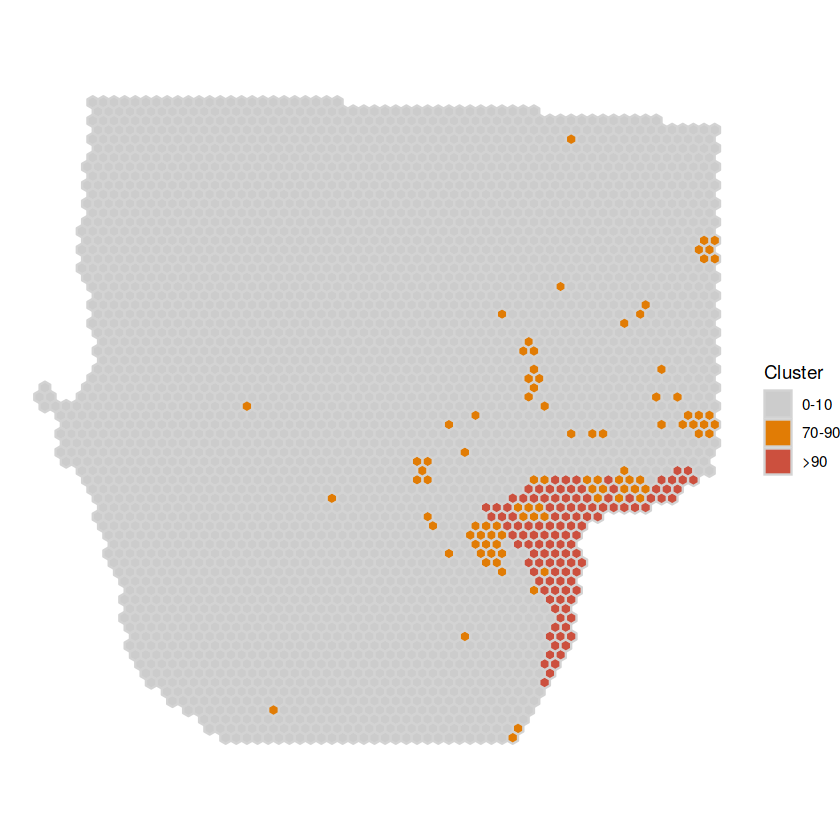

[1] "ST72"
  counted.gwas
1            2
2           39
3            3
4            0
5           11
6            7
7          113
8           58


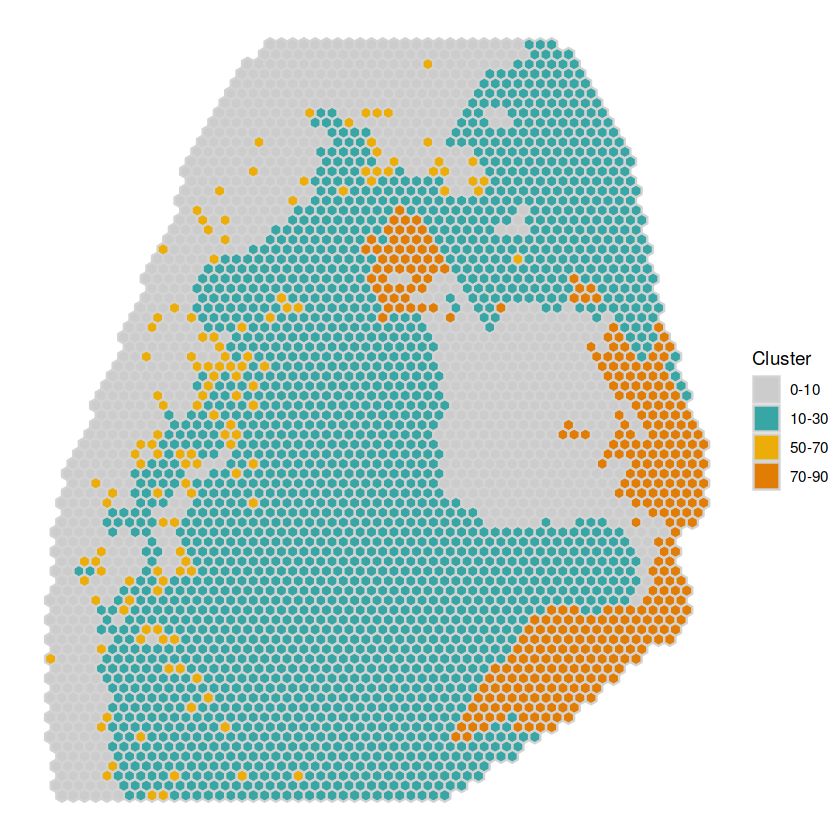

[1] "ST73"
  counted.gwas
1            5
2           27
3           35
4           57
5           22
6           18


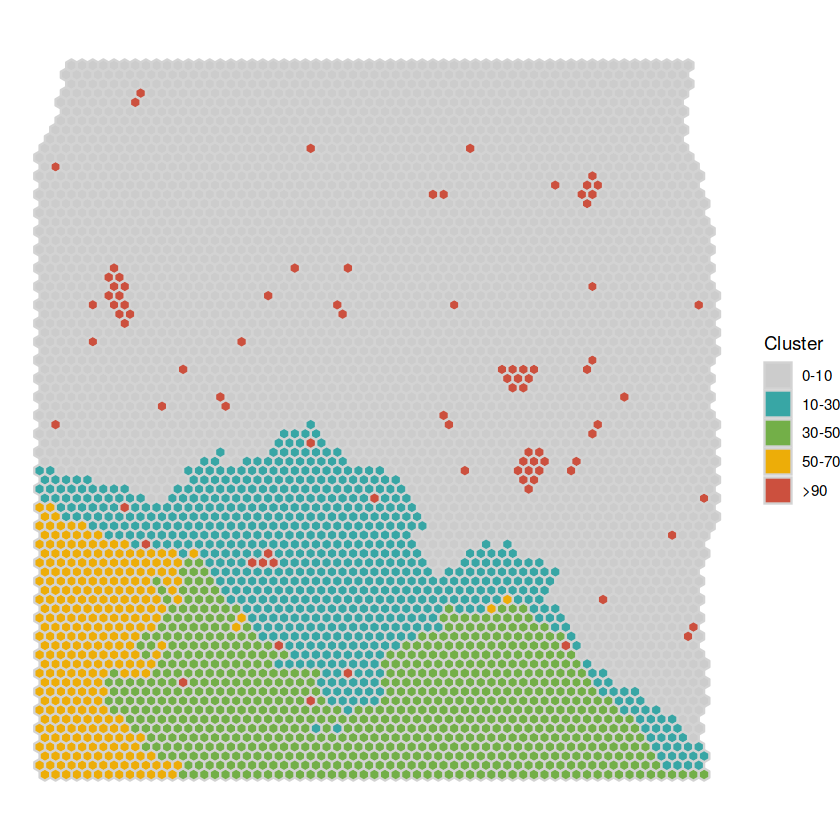

[1] "ST74"
  counted.gwas
1            6
2           36
3            8
4           13
5            5
6           88
7           12


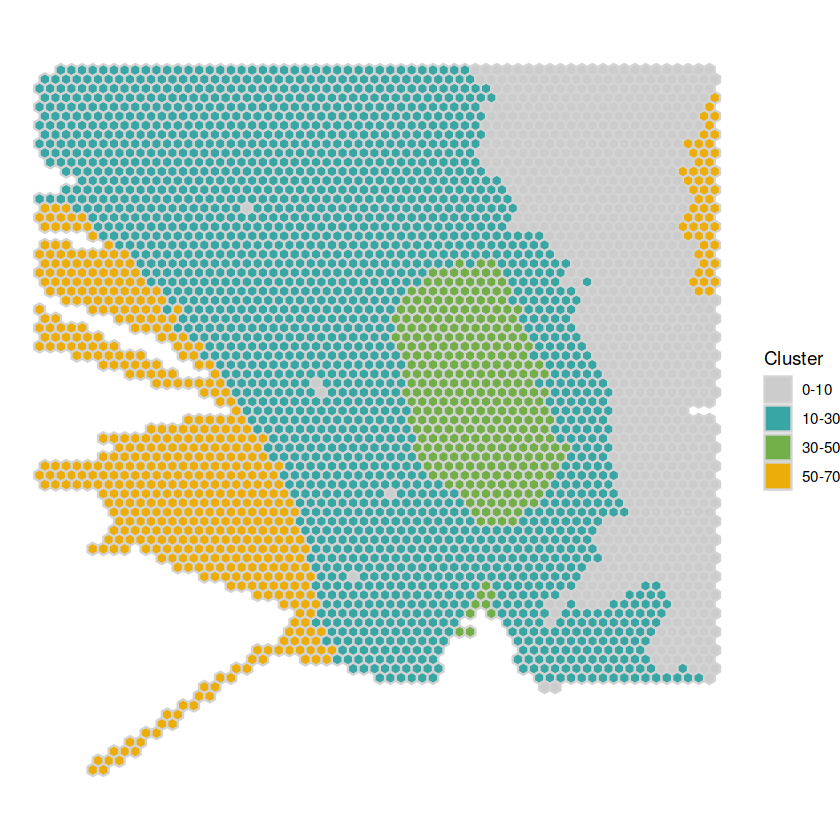

[1] "ST79"
  counted.gwas
1           40
2           27
3            2
4            0
5           14


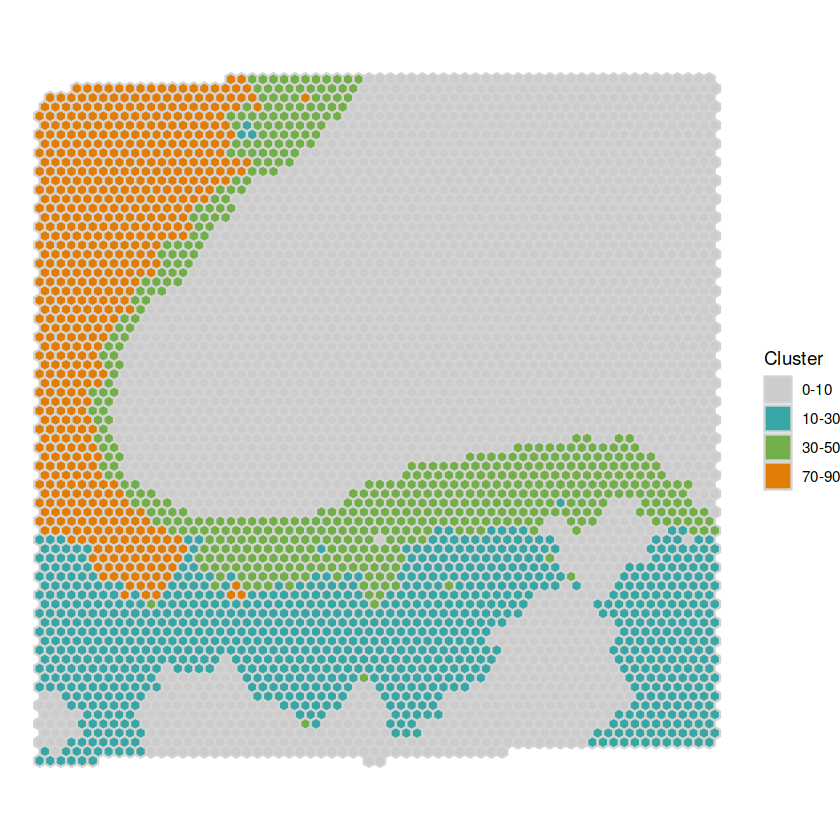

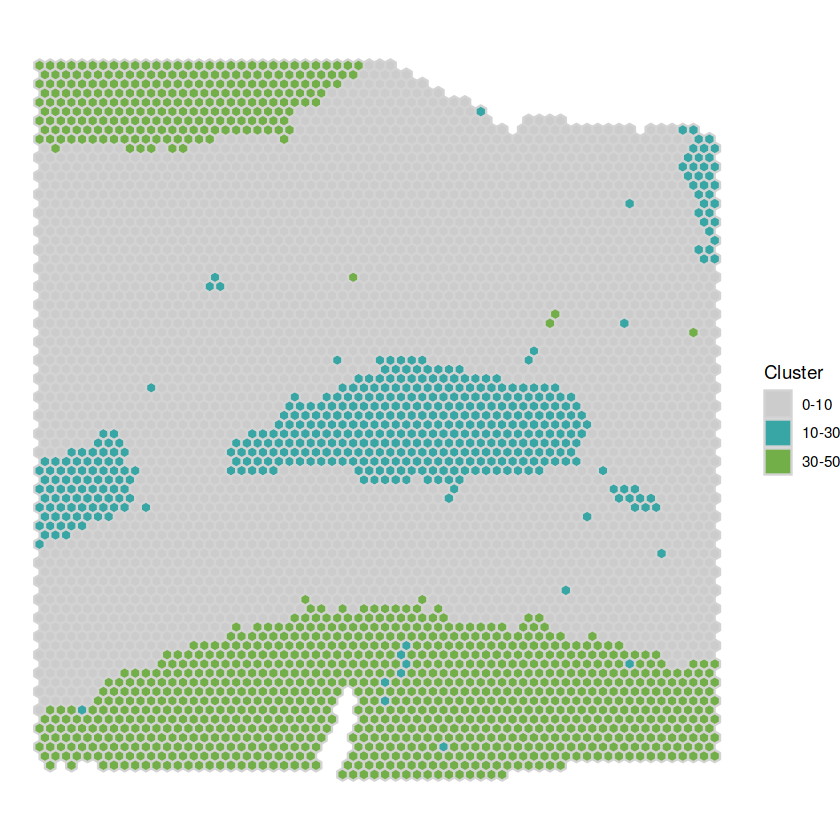

In [35]:
# vector of sample ids to process 
sampleIDs <- c("ST31", "ST32", "ST33", "ST34", 
"ST37", "ST38", "ST67", "ST68", 
"ST69", "ST70", "ST71","ST72",
"ST73", "ST74", "ST79") 

#' Bin and Plot GWAS Gene Expression Across Samples
#'
#' This script processes a list of SingleCellExperiment (SCE) objects, log-normalizes and scales their gene expression data,
#' aggregates the data across clusters, and counts the number of GWAS genes expressed in each cluster. The goal is to bin GWAS expression 
#' and generate plots for visualization.
#'
#' @param sampleIDs A vector of sample IDs to be processed.
#' @param indir The input directory containing the annotated SCE objects.
#' @param gwas.genes A vector of GWAS genes to be analyzed.

plot_GWAS_genes_per_cluster <- function(sampleIDs, indir, gwas.genes) {
  for (i in seq_along(sampleIDs)) {
    sampleID <- sampleIDs[i]
    print(sampleID)
    sce <- readRDS(file = paste0(indir, sampleID, "_sce_annotated.rds"))
    # Grouping variable is already present in this object (spatial.cluster)

    # Remove GM clusters
    sce <- sce[, !sce$identity %in% "GM"]
    my.ids <- sce$spatial.cluster

    # Normalize counts
    sce <- scuttle::logNormCounts(sce)

    # Aggregate mean expression per cluster
    avg.sce <- scuttle::aggregateAcrossCells(sce, ids = my.ids, statistics = "mean", use.assay.type = "logcounts")

    # Scale the log-normalized counts
    avg.genes <- as.matrix(logcounts(avg.sce))
    avg.z.genes <- scale(t(avg.genes))
    avg.z.genes <- t(avg.z.genes)
      
    # Remove genes with NA values in all clusters
    avg.z.genes <- avg.z.genes[rowSums(is.na(avg.z.genes)) != ncol(avg.z.genes), ]

    clusters <- colnames(avg.z.genes)
    counted.gwas <- NULL

    # Check if there are any GWAS genes present
    if (sum(rownames(avg.z.genes) %in% gwas.genes) == 0) {
      warning(paste("Warning: cannot compute", sampleID, ". There were no GWAS genes in the sample. Skipping this sample."))
      next
    }

    # Count the number of GWAS genes expressed per cluster
    for (j in seq_along(clusters)) {
      clusterx <- avg.z.genes[rownames(avg.z.genes) %in% gwas.genes, j]
      counted.gwas.x <- sum(clusterx > 1.5)
      counted.genes <- names(clusterx)[clusterx > 1.5]
      if (length(counted.genes) > 0) {
          write.csv(
          counted.genes, 
          file = paste0(outdir, "/", sampleID, "_cluster_", clusters[j], "_gwas-enrichment.csv")
        )
      }
      counted.gwas <- c(counted.gwas, counted.gwas.x)
    }

    # Bin the GWAS counts and plot
    if (sum(rownames(avg.z.genes) %in% gwas.genes) > 0) {
      names(counted.gwas) <- clusters
      counted.gwas <- as.data.frame(counted.gwas)
      print(counted.gwas)

      # Binning
      gwas.per.cluster <- counted.gwas %>%
        mutate(gwas.bin = case_when(
          counted.gwas >= 90 ~ '>90',
          counted.gwas >= 70 & counted.gwas < 90 ~ '70-90',
          counted.gwas >= 50 & counted.gwas < 70 ~ '50-70',
          counted.gwas >= 30 & counted.gwas < 50 ~ '30-50',
          counted.gwas >= 10 & counted.gwas < 30 ~ '10-30',
          counted.gwas < 10 ~ '0-10'
        ))

      gwas.per.cluster$spatial.cluster <- as.numeric(rownames(gwas.per.cluster))

      meta.sce <- colData(sce)

      # Merge the two data frames
      meta.updated <- merge(meta.sce, gwas.per.cluster, by = "spatial.cluster")
      unique(meta.updated$gwas.bin)

      meta.updated$gwas.bin <- factor(meta.updated$gwas.bin, levels = c('0-10', '10-30', '30-50', '50-70', '70-90', '>90'))
      custom_colors <- c("grey80", "#38A6A5", "#73AF48", "#EDAD08", "#E17C05", "#CC503E")
      names(custom_colors) <- levels(meta.updated$gwas.bin)

      colData(sce) <- meta.updated
      print(clusterPlot(
        sce,
        label = "gwas.bin",
        color = "lightgrey",
        palette = custom_colors
      ))
    }
  }
}

plot_GWAS_genes_per_cluster(sampleIDs, indir, gwas.genes)